# Backtesting strategies

### 1.-  SMA crossover example with SPY

https://pmorissette.github.io/bt/examples.html

In [1]:
import bt
import talib

In [2]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

#Here we construct the strategy
## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same structure
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

In [3]:
sma50.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2010-01-04 to 2022-01-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spy     2987 non-null   float64
dtypes: float64(1)
memory usage: 47.4 KB


In [4]:
#Data return close price of assets
data

,spy
Date,
2010-01-04,89.889229
2010-01-05,90.127174
2010-01-06,90.190628
2010-01-07,90.571335
2010-01-08,90.872726
...,...
2022-01-18,456.489990
2022-01-19,451.750000
2022-01-20,446.750000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2010-01-04 to 2022-01-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spy     3036 non-null   float64
dtypes: float64(1)
memory usage: 47.4 KB


In [6]:
#This is the strategy with WeightTarget
# For the purpose of setting target weights let's use WeighTarget. This algo will take a DataFrame of target weights that is pre-calculated.
# Basically, when the 50 day moving average will be above the 200-day moving average, we will be long (+1 target weight). Conversely, when the 50 is below the 200, we will be short (-1 target weight).
# target weihgts +1 is long and -1 is short
tw

,spy
Date,
2010-01-04,0.0
2010-01-05,0.0
2010-01-06,0.0
2010-01-07,0.0
2010-01-08,0.0
...,...
2022-01-18,1.0
2022-01-19,1.0
2022-01-20,1.0


In [8]:
tw.groupby('spy').size()

spy
-1.0     376
 0.0     199
 1.0    2461
dtype: int64

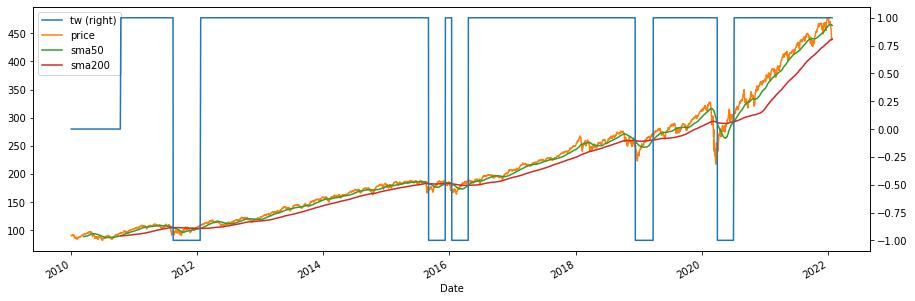

In [9]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [10]:
ma_cross = bt.Strategy('ma_cross', [bt.algos.WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

<AxesSubplot:title={'center':'Equity Progression'}>

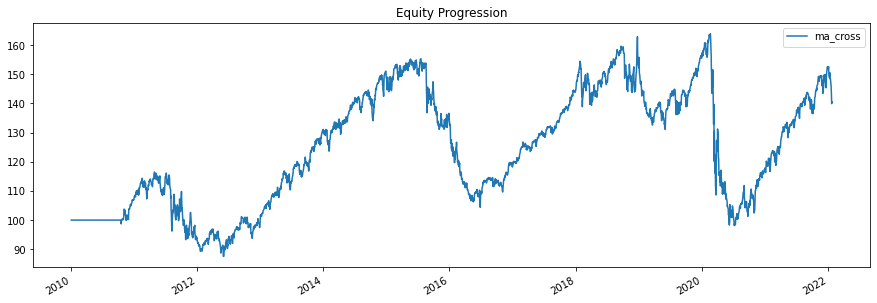

In [11]:
res.plot()

In [12]:
res.display()

Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2022-01-24
Risk-free rate       0.00%

Total Return         40.51%
Daily Sharpe         0.26
Daily Sortino        0.38
CAGR                 2.86%
Max Drawdown         -40.12%
Calmar Ratio         0.07

MTD                  -7.39%
3m                   -2.59%
6m                   0.65%
YTD                  -7.39%
1Y                   16.40%
3Y (ann.)            -0.83%
5Y (ann.)            3.15%
10Y (ann.)           4.62%
Since Incep. (ann.)  2.86%

Daily Sharpe         0.26
Daily Sortino        0.38
Daily Mean (ann.)    4.15%
Daily Vol (ann.)     16.24%
Daily Skew           -0.75
Daily Kurt           15.58
Best Day             9.06%
Worst Day            -10.94%

Monthly Sharpe       0.28
Monthly Sortino      0.41
Monthly Mean (ann.)  3.80%
Monthly Vol (ann.)   13.74%
Monthly Skew         -0.91
Monthly Kurt         1.46
Best Month           10.88%
Worst Month          -12.49%

# BTC backtesting strategies

In [13]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

### Extract info from exchange

In [14]:
def read_from_exchange(symbol: str) -> pd.DataFrame:
    """Extract candlestick data from Binance"""
    
    url_base = "https://api.binance.com/"
    url_endpoint = "api/v3/klines"
    binance_candlesticks = requests.get(url_base + url_endpoint + "?symbol={}USDT&interval=1d&limit=800".format(symbol))
    candlestick_info = binance_candlesticks.json()
    
    #Transform into Pandas dataframe to easy manipulation
    df = pd.DataFrame(candlestick_info)
    
    #changing column names
    df.columns = ["Opentime", "Open", "High", "Low", "Close", "Volume", "CloseTime", "QuoteAssetVolume", "NumberOfTrades", "TakerBuyBaseAssetVolume", "TakerBuyQuoteAssetVolume", "Ignore"]
    
    #changing types, objects to float, and unixtimestamp to timestamp
    df['Opentime'] = pd.to_datetime(df['Opentime'], unit='ms', dayfirst=True, origin= "unix")
    df['CloseTime'] = pd.to_datetime(df['CloseTime'], unit='ms', dayfirst=True, origin= "unix")
    df = df.astype({'Open':'float', 'High': 'float', 'Low': 'float', 'Close': 'float', 'Volume': 'float', 'QuoteAssetVolume': 'float64', 'TakerBuyBaseAssetVolume': 'float64', 'TakerBuyQuoteAssetVolume':'float64'})
    
    #setting date as index
    df = df.set_index("Opentime")
    
    return df

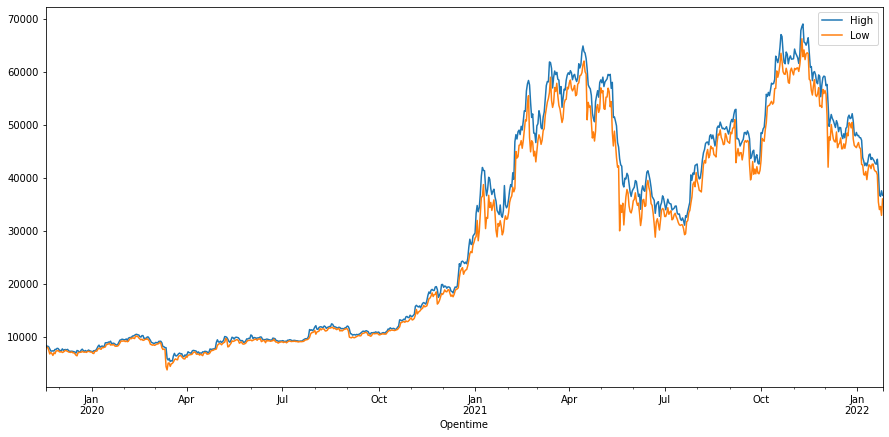

In [16]:
price_data = read_from_exchange('BTC')
price_data[['High', 'Low']].plot(figsize=(15, 7))
plt.show()

In [17]:
price_data.head()

,Open,High,Low,Close,Volume,CloseTime,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,Ignore
Opentime,,,,,,,,,,,
2019-11-18,8502.87,8503.52,8060.0,8187.17,43017.690940,2019-11-18 23:59:59.999,3.587062e+08,366263,20525.116924,1.712560e+08,0
2019-11-19,8186.50,8218.63,8003.0,8133.64,43556.061025,2019-11-19 23:59:59.999,3.534638e+08,357382,21816.725084,1.770616e+08,0
2019-11-20,8133.83,8264.29,8038.4,8098.01,32466.230980,2019-11-20 23:59:59.999,2.633876e+08,288843,16751.186459,1.359137e+08,0
2019-11-21,8098.56,8134.73,7500.0,7627.74,58418.780261,2019-11-21 23:59:59.999,4.551667e+08,430062,26902.369851,2.096693e+08,0
2019-11-22,7627.79,7750.00,6790.0,7268.23,126603.140259,2019-11-22 23:59:59.999,9.178815e+08,817604,60867.912182,4.413692e+08,0


In [18]:
price_data = price_data.loc[:, ['Close']]
price_data

,Close
Opentime,
2019-11-18,8187.17
2019-11-19,8133.64
2019-11-20,8098.01
2019-11-21,7627.74
2019-11-22,7268.23
...,...
2022-01-21,36445.31
2022-01-22,35071.42
2022-01-23,36244.55


## EMA crossover Strategy

In [19]:
#Here talib.EMA changes the column name (this causes problems with backtesting) be Careful Robert!!

#Calculate the indicators
EMA_20 = talib.EMA(price_data['Close'], timeperiod=20).to_frame()
#*probe with ema 50
EMA_50 = talib.EMA(price_data['Close'], timeperiod=50).to_frame()
EMA_100 = talib.EMA(price_data['Close'], timeperiod=100).to_frame()

EMA_20.columns = ['Close']
EMA_50.columns = ['Close']
EMA_100.columns = ['Close']

In [20]:
#Construct the signal

#Create the signal dataframe
signal = EMA_100.copy()
signal[EMA_100.isnull()] = 0

#Construct the signal
signal[EMA_20> EMA_100] = 1
signal[EMA_20 <= EMA_100] = -1
signal

,Close
Opentime,
2019-11-18,0.0
2019-11-19,0.0
2019-11-20,0.0
2019-11-21,0.0
2019-11-22,0.0
...,...
2022-01-21,-1.0
2022-01-22,-1.0
2022-01-23,-1.0


<AxesSubplot:xlabel='Opentime'>

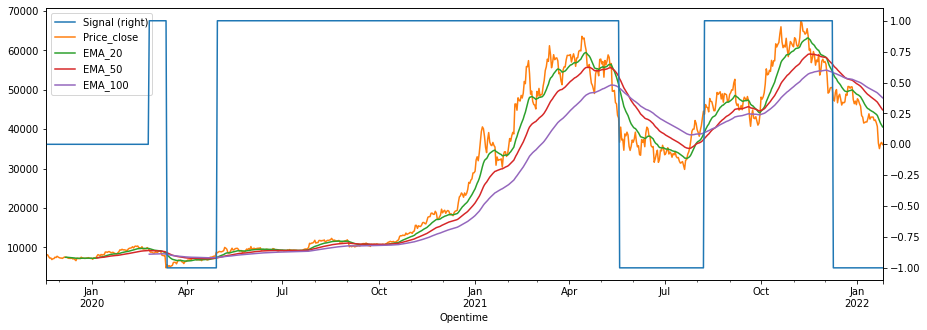

In [22]:
combined_df = bt.merge(signal, price_data, EMA_20, EMA_50, EMA_100)

#Plot the signal, price and MA
#combined_df = bt.merge(signal, price_data, EMA_short, EMA_long)
combined_df.columns = ['Signal', 'Price_close', 'EMA_20', 'EMA_50', 'EMA_100']
combined_df.plot(secondary_y = ['Signal'], figsize=(15, 5))

In [24]:
combined_df.fillna(value = 0, inplace = True)
combined_df.head()

,Signal,Price_close,EMA_20,EMA_50,EMA_100
Opentime,,,,,
2019-11-18,0.0,8187.17,0.0,0.0,0.0
2019-11-19,0.0,8133.64,0.0,0.0,0.0
2019-11-20,0.0,8098.01,0.0,0.0,0.0
2019-11-21,0.0,7627.74,0.0,0.0,0.0
2019-11-22,0.0,7268.23,0.0,0.0,0.0


In [25]:
#Define Strategy
ma_cross = bt.Strategy('EMA_crossover',
                         [bt.algos.WeighTarget(signal),
                         bt.algos.Rebalance()])

In [26]:
#Create the Backtest and run it
bt_backtest = bt.Backtest(ma_cross, price_data)
bt_result = bt.run(bt_backtest)

<AxesSubplot:title={'center':'Equity Progression'}>

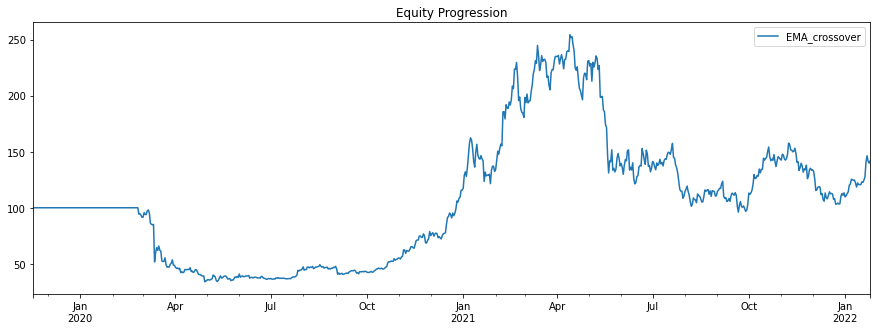

In [27]:
bt_result.plot()

In [28]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2019-11-17
End                  2022-01-25
Risk-free rate       0.00%

Total Return         41.97%
Daily Sharpe         0.50
Daily Sortino        0.75
CAGR                 17.35%
Max Drawdown         -66.09%
Calmar Ratio         0.26

MTD                  25.27%
3m                   -3.73%
6m                   8.30%
YTD                  25.27%
1Y                   10.00%
3Y (ann.)            17.35%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  17.35%

Daily Sharpe         0.50
Daily Sortino        0.75
Daily Mean (ann.)    31.02%
Daily Vol (ann.)     61.72%
Daily Skew           -1.30
Daily Kurt           15.14
Best Day             19.53%
Worst Day            -39.36%

Monthly Sharpe       0.61
Monthly Sortino      1.17
Monthly Mean (ann.)  52.26%
Monthly Vol (ann.)   85.02%
Monthly Skew         -0.10
Monthly Kurt         -0.36
Best Month           46.82%
Worst Month         